# Case-based Reasoning approach for Deep Reinforcement Learning Agents based on Proximal Policy Optimization

### Content:

### 1. Preprocessing of hyperparemeters (solutions)
### 2. Similarity learning using a Siamese neural network and Monte Carlo Dropout
### 3. Visualization of learned case embeddings and inductive bias
### 4. Retrieve process on reach Case
### 5. Retrieve process on position case

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, Lambda, Subtract, Layer, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# Loading preprocessed data (see Preprocessing.ipynb)
with open('data/case_vector_pairs_keys.pickle', 'rb') as handle:
    case_vector_pairs_keys = pickle.load(handle)
	
with open('data/case_vector_pairs_values.pickle', 'rb') as handle:
    case_vector_pairs_values = pickle.load(handle)
	
with open('data/encoded_cases.pickle', 'rb') as handle:
    encoded_cases = pickle.load(handle)
	
with open('data/encoded_case_vector_dict.pickle', 'rb') as handle:
    encoded_case_vector_dict = pickle.load(handle)
	
with open('data/col_values_dict.pickle', 'rb') as handle:
    col_values_dict = pickle.load(handle)

# 1. Preprocessing of hyperparemeters (solutions)

## Hyperparameters before processing

In [3]:
hyperparameters = pd.read_csv('data/Hyperparameters.csv', delimiter=';', index_col = 'Case Number')
hyperparameters.iloc[:,:] = hyperparameters.iloc[:,:].astype('float32')
hyperparameters.head()

,Gamma,Lambda,Horizon,Batch Size,Buffer Size,Epochs,Learning Rate,Hidden Units,Hidden Layer,Convolutional Layer,Memory Size
Case Number,,,,,,,,,,,
1,0.995,0.95,1000.0,512.0,20480.0,3.0,0.0003,128.0,2.0,0.0,0.0
2,0.900,0.95,3.0,32.0,256.0,3.0,0.0003,20.0,1.0,0.0,0.0
3,0.990,0.99,1000.0,64.0,12000.0,3.0,0.0003,128.0,2.0,0.0,0.0
4,0.900,0.95,5.0,32.0,256.0,3.0,0.0003,256.0,1.0,2.0,0.0
5,0.990,0.95,64.0,128.0,2048.0,3.0,0.0003,256.0,1.0,2.0,0.0


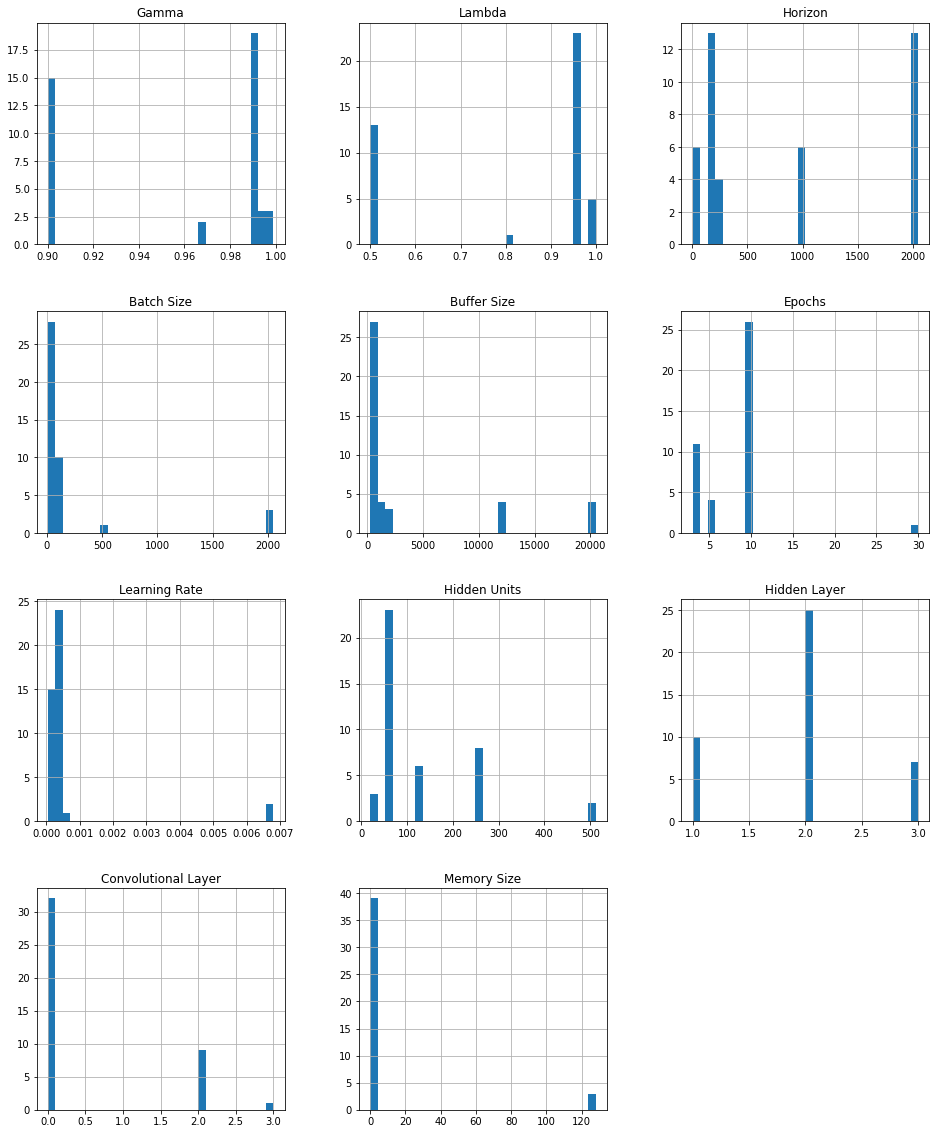

In [4]:
column_list = hyperparameters.columns.values.tolist()
hyperparameters.hist(column = column_list, bins=30, figsize=(16, 20));

## Hyperparameters after input warping

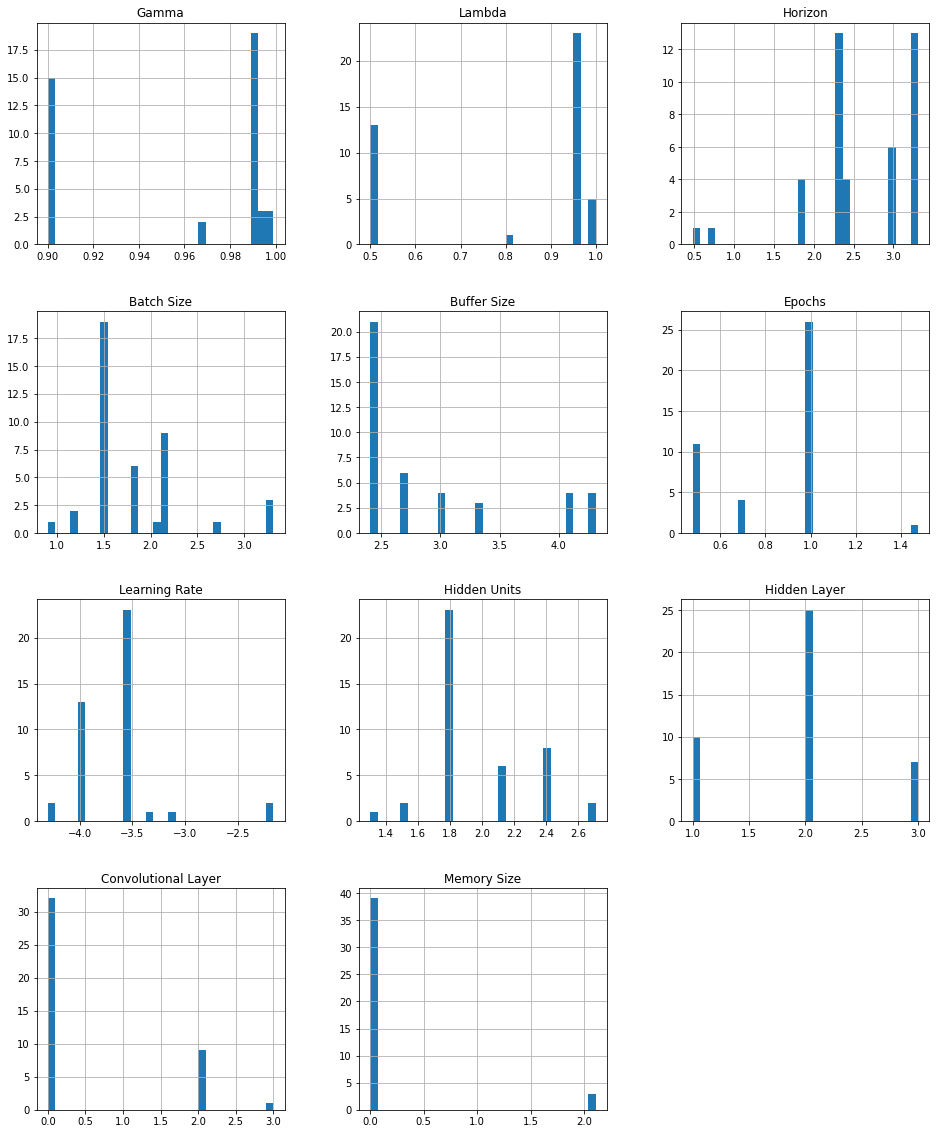

In [5]:
hyperparameters_warped = hyperparameters.copy()
hyperparameters_warped.iloc[:,2:8] = np.log10(hyperparameters_warped.iloc[:,2:8])
# Warping Memory Size separately since it has zeros
ms_norm = []
for i in hyperparameters_warped['Memory Size']:
    if i!=0:
        ms_norm.append(np.log10(i))
    else:
        ms_norm.append(i)
hyperparameters_warped['Memory Size'] = ms_norm
hyperparameters_warped.hist(column = column_list, bins=30, figsize=(16, 20));

## Hyperparameters after input warping and normalization

In [6]:
def manhattan_distance_similarity(hyperpara_sim_df, column_name):
    '''
    Calculates the distance between two case hyperparameter values and scales them in the range [0, 1] by dividing with 
    the maximum distance between two cases for a hyperparameter.
    
    A value of 0 indicates no difference between two cases and therefore means the two cases are exactly similar.
    A value of 1 indicates the maximum difference between two cases and therefore means the two cases are extremely 
    dissimilar
    '''
    column_name_dict_manh = hyperpara_sim_df[column_name].to_dict()
    case_pair_column_name_manh = list(itertools.combinations_with_replacement(column_name_dict_manh.values(), 2))
    
    column_name_manh_similarity = []
    
    for i in case_pair_column_name_manh:
        inp_1 = i[0]
        inp_2 = i[1]
        
        L1_manh_distance = np.linalg.norm(inp_1 - inp_2)
        norm_L1_simi = L1_manh_distance/(hyperpara_sim_df[column_name].max() - hyperpara_sim_df[column_name].min())
        
        column_name_manh_similarity.append(norm_L1_simi)
    
    column_name_manh_similarity = np.asarray([column_name_manh_similarity])
    column_name_manh_similarity = np.transpose(column_name_manh_similarity)
    
    return column_name_manh_similarity

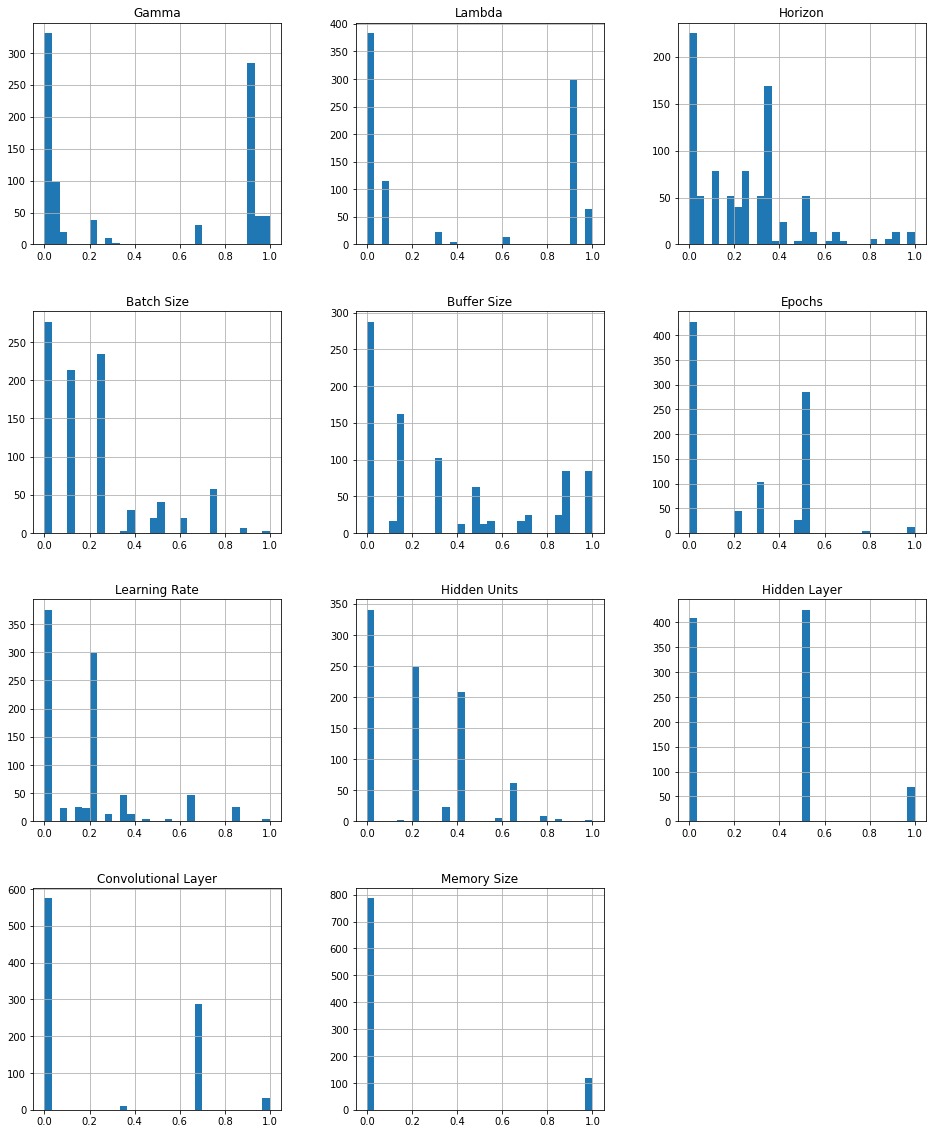

In [7]:
dfg = []

for i in column_list:
    dfg.append(manhattan_distance_similarity(hyperparameters_warped, i))
    
hyperpara_sim = np.column_stack((dfg))
case_similarity_df = pd.DataFrame(hyperpara_sim, columns=column_list, index = case_vector_pairs_keys)
case_similarity_df.hist(column = column_list, bins=30, figsize=(16, 20));

# 2. Similarity learning using a Siamese neural network and Monte Carlo Dropout

## Generating the train and test data from case-pairs

In [8]:
seed = 7
np.random.seed(seed)
hyperpara_L1_simi = case_similarity_df.values

X_train, X_test, y_train, y_test = train_test_split(case_vector_pairs_values, hyperpara_L1_simi, test_size=0.15, random_state=seed)

In [9]:
# Separating inputs based on case_vector_pair_dataset to be given to the Siamese neural network

i_1 = []
i_2 = []
t_1 = []
t_2 = []

for i in X_train:
    i_1.append(i[0])
    
for j in X_train:
    i_2.append(j[1])

for k in X_test:
    t_1.append(k[0])

for l in X_test:
    t_2.append(l[1])

X_train_1 = np.array(i_1)   # Contains all first encoded_case_vectors of the case pair
X_train_2 = np.array(i_2)   # Contains all second encoded_case_vectors of the case pair
X_test_1 = np.array(t_1)
X_test_2 = np.array(t_2)

In [10]:
max_length = 84
list_of_lists = []

for i in range(max_length):
    list_of_lists.append(float(i))

for idx, item in enumerate(list_of_lists):
    if item != 0:
        list_of_lists[idx] = 1.0

new_list = [[el] for el in list_of_lists]

## Definition of custom layers

In [11]:
class PaddedLookUp(Layer):
    def __init__(self, input_dim, output_dim, initializer, **kwargs):
        super(PaddedLookUp, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.initializer = initializer
        
        def build(self, input_shape):
            self.embeddings = self.add_weight(
            shape=(self.input_dim, self.output_dim),
            embeddings_initializer=self.initializer,
            dtype="float32",
            trainable = False)
        
        def call(self, inputs, trainable = False):
            return tf.nn.embedding_lookup(self.embeddings, inputs)

In [12]:
class Multiply(Layer):
    def __init__(self, input_dim, output_dim, **kwargs):
        super(Multiply, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, input_1, input_2, trainable = True): # Defines the computations from inputs to outputs
        return tf.multiply(input_1, input_2)

In [13]:
def custom_layer(tensor):
    '''returns a sum of values on the second axis'''
    return tf.math.reduce_sum(tensor, axis=1, keepdims=True)

## Configuration of the Siamese neural network and training/validating on case-pairs

In [14]:
def nll(y, distr):
    return -distr.log_prob(y)

vocab_size = 18
max_length = 84

common_embed = Embedding(input_dim = vocab_size + 1,
                         output_dim = 10,
                         input_length = max_length,
                         mask_zero = True,
                         embeddings_initializer = tf.keras.initializers.RandomUniform(minval=0.0001, maxval=0.001, seed=15),
                         name = "Word_Embeddings")


inp1 = Input(shape=(case_vector_pairs_values[0][0].shape[0],), name= "Case_A")     
common_multiply = Multiply(input_dim = max_length, output_dim = 3)
padded_lookup = PaddedLookUp(input_dim=84, output_dim=3, initializer = new_list)


word_embeddings_1 = common_embed(inp1)
mask_padding_input_1 = tf.expand_dims(padded_lookup(inp1), axis=2)
masked_padded_embedding_1 = common_multiply(word_embeddings_1, tf.dtypes.cast(mask_padding_input_1, tf.float32))
lambda_layer_1 = Lambda(custom_layer)(masked_padded_embedding_1)
case_embeddings_1 = Flatten(name="Case_Embeddings_1")(lambda_layer_1)



inp2 = Input(shape=(case_vector_pairs_values[0][1].shape[0],), name= "Case_B")     
word_embeddings_2 = common_embed(inp2)
mask_padding_input_2 = tf.expand_dims(padded_lookup(inp2), axis=2)
masked_padded_embedding_2 = common_multiply(word_embeddings_2, tf.dtypes.cast(mask_padding_input_2, tf.float32))
lambda_layer_2 = Lambda(custom_layer)(masked_padded_embedding_2)
case_embeddings_2 = Flatten(name="Case_Embeddings_2")(lambda_layer_2)


out = Subtract(name = "Case_Pair_Subtraction")([case_embeddings_1, case_embeddings_2])


out = Dense(256,activation="relu")(out)
out = Dropout(0.9)(out, training=True)
out = Dense(512,activation="relu")(out)
out = Dropout(0.2)(out, training=True)

params_mc = Dense(22,activation="tanh")(out)

dist = tfpl.IndependentNormal(11)(params_mc)


# Model to predict case pair similarity
model_cps = Model([inp1, inp2], dist)

layer_name = "Case_Embeddings_1"
intermediate_layer_model = Model(inputs = inp1, outputs=model_cps.get_layer(layer_name).output)

# Compile the model
model_cps.compile(optimizer=Adam(learning_rate=0.001), loss=nll)

In [15]:
# Fit the model
history = model_cps.fit(
                    [X_train_1, X_train_2], 
                    y_train, 
                    epochs=100,
                    batch_size=32,
                    validation_data=([X_test_1, X_test_2] ,y_test))

Epoch 1/100
24/24 [==============================] - 1s 14ms/step - loss: 7.3337 - val_loss: 4.8415
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 4.4478 - val_loss: 3.6461
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 3.5050 - val_loss: 3.6321
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 3.3356 - val_loss: 3.1836
Epoch 5/100
24/24 [==============================] - 0s 4ms/step - loss: 2.9664 - val_loss: 2.5048
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 2.3850 - val_loss: 2.8700
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 2.5409 - val_loss: 2.4106
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 2.3285 - val_loss: 2.3847
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 2.1360 - val_loss: 2.2936
Epoch 10/100
24/24 [==============================] - 0s 3ms/step - loss: 2.1174 - val_loss: 1.8070
Epoch 11

<function matplotlib.pyplot.show(close=None, block=None)>

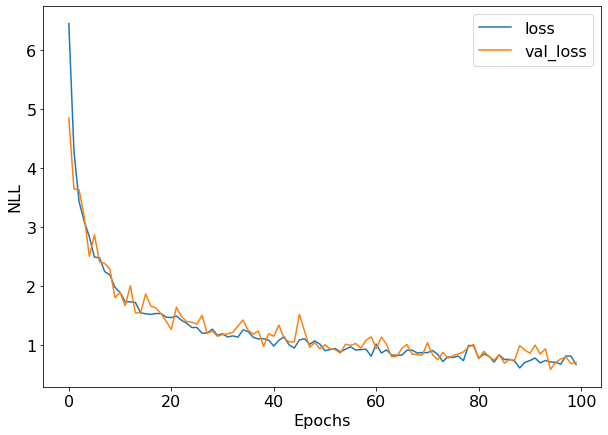

In [16]:
# Evaluate the model
loss = model_cps.evaluate([X_test_1, X_test_2], y_test, verbose=False)
plt.rcParams.update({'font.size': 16})

plt.figure(figsize = (10,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.show

# 3. Visualization of learned case embeddings and inductive bias

In [17]:
weights_embedded_layer = np.array(model_cps.layers[5].get_weights())
weights_embedded_layer_2d = np.squeeze(weights_embedded_layer, axis=0)
weights_embedded_layer_2d[col_values_dict.get('Scalar')]

intermediate_output = intermediate_layer_model.predict(encoded_cases)

case_to_embedding = {}

for x in range(len(intermediate_output)):
    case_to_embedding["case_{0}".format(x+1)] = intermediate_output[x]

In [18]:
from sklearn.decomposition import PCA

labels_cases = []
tokens_cases = []

for word in case_to_embedding.values():
    tokens_cases.append(word)
    
pca_model = PCA(n_components=2)
new_values_c = pca_model.fit_transform(tokens_cases)

In [19]:
df = pd.DataFrame(new_values_c)
cam = [0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
memory = [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
df['cam'] = cam
df['memory'] = memory
df.columns = ['x', 'y', 'cam', 'memory']

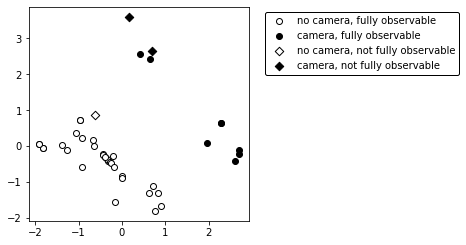

In [20]:
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'figure.figsize': [10/2.54, 10/2.54]})
plt.rcParams.update({'legend.edgecolor': 'black'})
plt.rcParams.update({'legend.edgecolor': 'black'})
plt.rcParams.update({'legend.framealpha': 1.0})


fig = plt.figure()
ax1 = fig.add_subplot(111)

df_no_cam = df.loc[df['cam'].eq(0)]
df_cam = df.loc[df['cam'].eq(1)]

df_no_cam_no_mem = df_no_cam.loc[df['memory'].eq(0)]
df_no_cam_mem = df_no_cam.loc[df['memory'].eq(1)]

df_cam_no_mem = df_cam.loc[df['memory'].eq(0)]
df_cam_mem = df_cam.loc[df['memory'].eq(1)]


ncnm = ax1.scatter(x=df_no_cam_no_mem['x'], y=df_no_cam_no_mem['y'], c='white', marker="o", edgecolors= 'black')
ncm = ax1.scatter(x=df_no_cam_mem['x'], y=df_no_cam_mem['y'], c='white', marker="D", edgecolors= 'black')
cnm = ax1.scatter(x=df_cam_no_mem['x'], y=df_cam_no_mem['y'], c='black', marker="o", edgecolors= 'black')
cm = ax1.scatter(x=df_cam_mem['x'], y=df_cam_mem['y'], c='black', marker="D", edgecolors= 'black')

ax1.legend(handles=[ncnm, cnm, ncm, cm], labels=['no camera, fully observable', 'camera, fully observable', 'no camera, not fully observable', 'camera, not fully observable'], bbox_to_anchor=(1.05, 1))

#fig.savefig('embeddings.svg', format='svg')
fig.show()

# 4. Retrieve process on reach Case

## Possible semantic elements to describe a new case

In [21]:
print('possible semantic elements:')
col_values_dict

possible semantic elements:


{'Skill:Reach': 5,
 'Skill:Fixate': 6,
 'Skill:Push': 7,
 'Skill:Slide': 8,
 'Skill:Pick&Place': 9,
 'Skill:Orient': 10,
 'Condition:Moving_Target': 11,
 'Condition:With_Collision': 12,
 'Condition:Keep_in_Position': 13,
 'Action:Continious': 14,
 'Action:Discrete': 15,
 'Observation:Scalar': 16,
 'Observation:Visual(2D)': 17,
 'Condition:Not_fully_observable)': 18}

## Creating a new case embedding and retrieve of the nearest case from the case base

In [22]:
# Reach Task = [1*Reach(5), 1*With Collision(12), 6*Continuous Action(14), 24*Scalar Observation(16)]

reach_task = [[5, 12, 14, 14, 14, 14, 14, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]]
reach_task_padded = pad_sequences(reach_task, padding='post', truncating='post', maxlen=84)
reach_case = np.array(reach_task_padded)

In [23]:
def rescaled_endpoint_values(hyperparameter):

    # Calculate the values of the end points of distribution values within the first standard deviation

    scaled_right_endpoint = hp_mean_values_dict[hyperparameter] + hp_std_values_dict[hyperparameter]
    scaled_left_endpoint = hp_mean_values_dict[hyperparameter] - hp_std_values_dict[hyperparameter]
    
    # Rescale the mean, left_endpoint, right_endpoint to their values

    rescaled_mean = (hp_mean_values_dict[hyperparameter] * 
                     (hyperparameters[hyperparameter].max() - hyperparameters[hyperparameter].min())) + most_similar_case_hyperparameters[hyperparameter]

    rescaled_left_endpoint = (scaled_left_endpoint * 
                            (hyperparameters[hyperparameter].max() - hyperparameters[hyperparameter].min())) + most_similar_case_hyperparameters[hyperparameter]

    rescaled_right_endpoint = (scaled_right_endpoint * 
                            (hyperparameters[hyperparameter].max() - hyperparameters[hyperparameter].min())) + most_similar_case_hyperparameters[hyperparameter]

    
    return rescaled_left_endpoint, rescaled_mean, rescaled_right_endpoint

In [24]:
# Manhattan Distance to Reach Case
from scipy.spatial.distance import cdist
reach_case_embedding = intermediate_layer_model.predict(reach_case)
xx = reach_case_embedding.reshape(1, -1)
yy = intermediate_output.reshape(1, -1)
reach_dist = cdist(xx, intermediate_output, 'cityblock')
reach_nearest_case = reach_dist.argmin()
print('Nearest Case = Case ' + str(reach_dist.argmin()+1))

Nearest Case = Case 1


In [25]:
prediction_reach = model_cps([reach_case, encoded_cases[[reach_nearest_case]]])
prediction_reach_mean = prediction_reach.mean()
prediction_reach_std = prediction_reach.stddev()
hyperpara_dist_mean = prediction_reach_mean.numpy()[0]
hp_mean_values_dict = dict(zip(column_list, hyperpara_dist_mean.tolist()))
hyperpara_std = prediction_reach_std.numpy()[0]
hp_std_values_dict = dict(zip(column_list, hyperpara_std.tolist()))
most_similar_case_hyperparameters = hyperparameters.loc[reach_nearest_case+1]
most_similar_case_hyperparameters

Gamma                      0.9950
Lambda                     0.9500
Horizon                 1000.0000
Batch Size               512.0000
Buffer Size            20480.0000
Epochs                     3.0000
Learning Rate              0.0003
Hidden Units             128.0000
Hidden Layer               2.0000
Convolutional Layer        0.0000
Memory Size                0.0000
Name: 1, dtype: float32

## Plotting the hyperparameter ranges

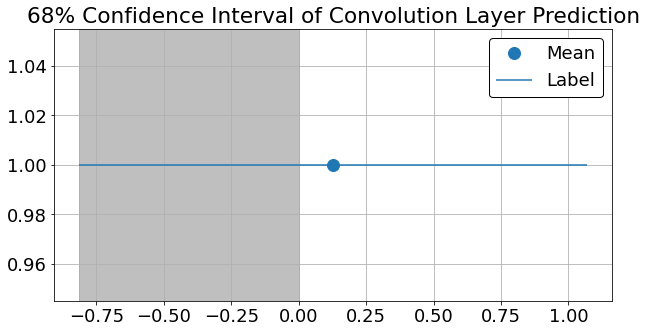

In [26]:
left_endpoint, mean, right_endpoint = rescaled_endpoint_values('Convolutional Layer')

fig = plt.figure(figsize = (10,5))
plt.rcParams.update({'font.size': 18})

plt.hlines( 1, left_endpoint, right_endpoint, label='Label')
plt.title('68% Confidence Interval of Convolution Layer Prediction')
plt.grid()
plt.plot(mean, 1, 'o', markersize=12, lw=2, label='Mean')
plt.axvspan(left_endpoint, 0, color='grey', alpha=0.5)
plt.legend()

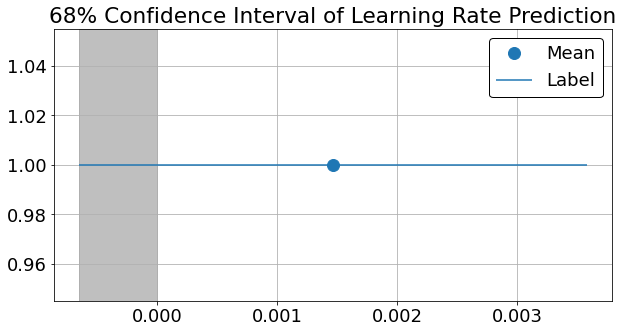

In [27]:
left_endpoint, mean, right_endpoint = rescaled_endpoint_values('Learning Rate')
fig = plt.figure(figsize = (10,5))
plt.rcParams.update({'font.size': 18})
plt.hlines( 1, left_endpoint, right_endpoint, label='Label')
plt.title('68% Confidence Interval of Learning Rate Prediction')
plt.grid()
plt.plot(mean, 1, 'o', markersize=12, lw=2, label='Mean')
plt.axvspan(left_endpoint, 0, color='grey', alpha=0.5)
plt.legend()

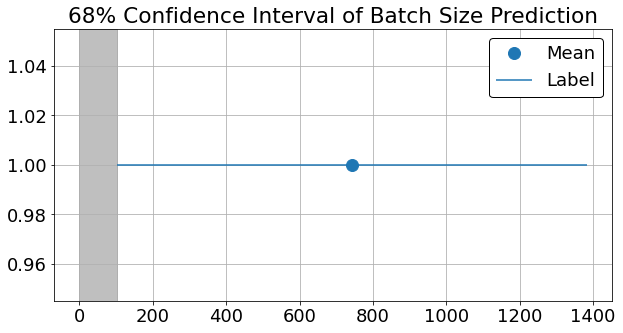

In [28]:
left_endpoint, mean, right_endpoint = rescaled_endpoint_values('Batch Size')
fig = plt.figure(figsize = (10,5))
plt.rcParams.update({'font.size': 18})
plt.hlines( 1, left_endpoint, right_endpoint, label='Label')
plt.title('68% Confidence Interval of Batch Size Prediction')
plt.grid()
plt.plot(mean, 1, 'o', markersize=12, lw=2, label='Mean')
plt.axvspan(left_endpoint, 0, color='grey', alpha=0.5)
plt.legend()

# 5. Retrieve process on position Case

In [29]:
# Position = Reach + Orient
# Position Task = [1*Reach(5), 1*Orient(10), 6*Continuous Action(14), 1*Visual Observation(17)]

position_task = [[5, 10, 14, 14, 14, 14, 14, 14, 17]]
position_task_padded = pad_sequences(position_task, padding='post', truncating='post', maxlen=84)
position_case = np.array(position_task_padded)

In [30]:
# Manhattan Distance to Position Case
from scipy.spatial.distance import cdist
position_case_embedding = intermediate_layer_model.predict(position_case)
xx = position_case_embedding.reshape(1, -1)
yy = intermediate_output.reshape(1, -1)
position_dist = cdist(xx, intermediate_output, 'cityblock')
position_nearest_case = position_dist.argmin()
print('Nearest Case = Case ' + str(position_nearest_case+1))
most_similar_case_hyperparameters = hyperparameters.loc[position_nearest_case+1]
most_similar_case_hyperparameters

Nearest Case = Case 4


Gamma                    0.9000
Lambda                   0.9500
Horizon                  5.0000
Batch Size              32.0000
Buffer Size            256.0000
Epochs                   3.0000
Learning Rate            0.0003
Hidden Units           256.0000
Hidden Layer             1.0000
Convolutional Layer      2.0000
Memory Size              0.0000
Name: 4, dtype: float32

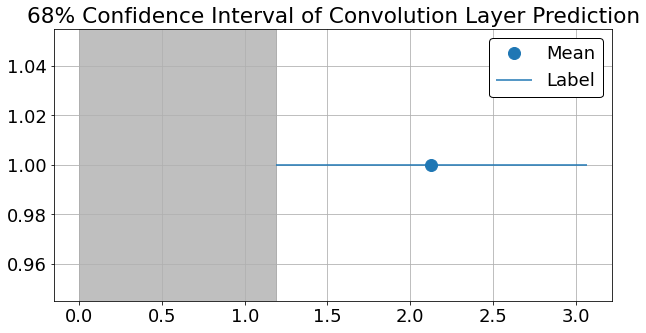

In [31]:
left_endpoint, mean, right_endpoint = rescaled_endpoint_values('Convolutional Layer')
fig = plt.figure(figsize = (10,5))
plt.rcParams.update({'font.size': 18})
plt.hlines( 1, left_endpoint, right_endpoint, label='Label')
plt.title('68% Confidence Interval of Convolution Layer Prediction')
plt.grid()
plt.plot(mean, 1, 'o', markersize=12, lw=2, label='Mean')
plt.axvspan(left_endpoint, 0, color='grey', alpha=0.5)
plt.legend()

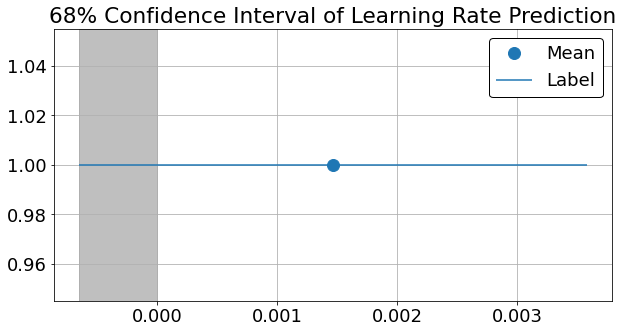

In [32]:
left_endpoint, mean, right_endpoint = rescaled_endpoint_values('Learning Rate')
fig = plt.figure(figsize = (10,5))
plt.rcParams.update({'font.size': 18})
plt.hlines( 1, left_endpoint, right_endpoint, label='Label')
plt.title('68% Confidence Interval of Learning Rate Prediction')
plt.grid()
plt.plot(mean, 1, 'o', markersize=12, lw=2, label='Mean')
plt.axvspan(left_endpoint, 0, color='grey', alpha=0.5)
plt.legend()

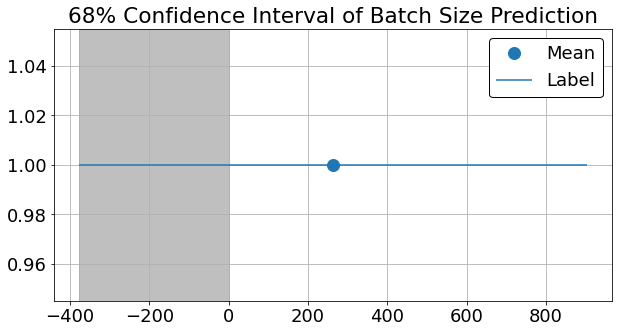

In [33]:
left_endpoint, mean, right_endpoint = rescaled_endpoint_values('Batch Size')
fig = plt.figure(figsize = (10,5))
plt.rcParams.update({'font.size': 18})
plt.hlines( 1, left_endpoint, right_endpoint, label='Label')
plt.title('68% Confidence Interval of Batch Size Prediction')
plt.grid()
plt.plot(mean, 1, 'o', markersize=12, lw=2, label='Mean')
plt.axvspan(left_endpoint, 0, color='grey', alpha=0.5)
plt.legend()